In [1]:
import pandas as pd
from typing import Iterable, Literal, overload
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 as cv
import numpy as np
import math
import os
import hashlib, json

In [2]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array

2025-11-10 21:40:15.086788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-10 21:40:15.131666: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-10 21:40:15.141468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-10 21:40:15.179841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-10 21:40:16.709538: W tensorflow/compiler/tf2

# Sample Image To Check Implementations On

In [4]:
SAMPLE_IMAGE = 'test_1.jpg'
SAMPLE_IMAGE_2 = 'test_2.jpg'

Image Dimensions: (1, 300, 300, 3)


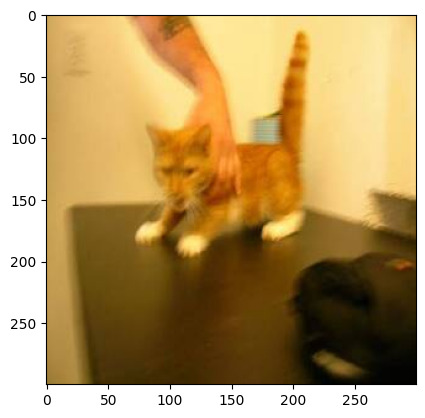

In [5]:
img_pre = load_img(SAMPLE_IMAGE,target_size=(300,300))
img_pre = img_to_array(img_pre)
img_pre = np.divide(img_pre,255.0)
plt.imshow(img_pre)
img_pre = np.expand_dims(img_pre,axis=0)
print(f'Image Dimensions: {img_pre.shape}')

# Implementing Anchor Functions

In [6]:
image_size = (300,300)
feature_map_shapes = [(28,28), (14,14), (7,7), (4,4), (2,2)]
s_min = 0.2
s_max = 0.9
aspect_ratios = [[1,2,0.5],[1,2,0.5],[1,2,0.5,3,1/3],[1,2,0.5,3,1/3],[1,2,0.5]]

## Calculating Feature Map Sizes

In [7]:
strides = [8,16,32,64,128,224]

In [8]:
def calculate_feature_map_shapes(image_shape: tuple[int,int], strides: [int]):
    
    # Calculating the feature map size for the image
    assert isinstance(image_shape[0], int) and isinstance(image_shape[1], int), "image_shape must be (int, int) pixels"
    assert image_shape[0] >= 0, f"Image shape cannot be 0"
    assert all(isinstance(s, int) and s > 0 for s in strides), "all strides must be positive ints"

    fm_h = [math.ceil(image_shape[0]/stride) for stride in strides]
    fm_w = [math.ceil(image_shape[1]/stride) for stride in strides]

    return [(fm_h[k],fm_w[k]) for k in range(len(fm_h))]

In [9]:
calculate_feature_map_shapes((224,224),strides)

[(28, 28), (14, 14), (7, 7), (4, 4), (2, 2), (1, 1)]

## Calculating Scales & Aspect Ratio Per Layer

In [10]:
def _calculate_scale_at_layer_number(layer_number: int, s_min: float, s_max: float, num_of_layers: int):
    if num_of_layers == 1:
        return s_min
    return (s_min + (((s_max - s_min)/(num_of_layers - 1)) * (layer_number - 1)))

def _calculate_default_box_scale(s_k,s_knext):
    return math.sqrt(s_k * s_knext)

def compute_scales_per_layer(scales: list[float] | None, number_of_layers: int, s_min: float, s_max: float, include_extra: bool = False):
    assert number_of_layers >= 1, "Number of layers must be >=1"
    if scales is not None:
        # Scales are explicit
        assert len(scales) == number_of_layers, f"Length of scales: {len(scales)} != {number_of_layers}"
        for scale in scales:
            assert 0.0 < scale <= 1.0, f"Scales must be in the in space (0,1]"
    else:
        assert 0.0 < s_min <= s_max <= 1.0, "Require 0 < s_min ≤ s_max ≤ 1"
        scales = [_calculate_scale_at_layer_number(k,s_min,s_max,number_of_layers) for k in range(1,number_of_layers+1)]

    if include_extra:
        return [[scales[k],_calculate_default_box_scale(scales[k],1)] if k == number_of_layers - 1 else [scales[k],_calculate_default_box_scale(scales[k],scales[k+1])  ]  for k in range(len(scales))]
    else:
        return [[s_k] for s_k in scales]

In [11]:
compute_scales_per_layer(scales = None, number_of_layers = 4, s_min=0.2, s_max = 0.8, include_extra = True)

[[0.2, 0.28284271247461906],
 [0.4, 0.48989794855663565],
 [0.6000000000000001, 0.692820323027551],
 [0.8, 0.8944271909999159]]

In [12]:
def _sanitize_aspect_ratios(aspect_ratios : [float]):
    # Checking for three different things:
    # 1. Check for duplications
    # 2. Ensure 1.0 exists if all the values are filtered
    # 3. Ordering in the format [1.0, > 1.0, < 1.0]

    # Checking for duplications
    duplicate = {}
    filtered_values = []
    for ratio in aspect_ratios:
        cast_ratio = round(float(ratio),6)
        if cast_ratio in duplicate:
            # This is a duplicate and doesnt need to be added
            continue
        else:
            # This is not a duplicate so it needs to be added to the dict and then added to the filtered values
            duplicate[cast_ratio] = 1
            filtered_values.append(cast_ratio)

    # Check if 1.0 exists in the list
    if 1.0 in filtered_values:
        # Remove it
        filtered_values.remove(1.0)

    # Ordering the information
    filtered_values.sort(key=lambda v: (v < 1.0, v if v > 1.0 else -v))

    # Adding the 1 at the beginning
    return [1] + filtered_values
    
def standardize_aspect_ratios(aspect_ratios: [[float]], number_of_layers : int):
    # Performing a bunch of sanity checks
    # assert all((isinstance(ratio, float) or isinstance(ratio, int)) and ratio > 0 for ratio in aspect_ratios), "all ratios must be positive number"
    assert len(aspect_ratios) >= 1, "There must be more than one aspect ratio layer present"
    assert number_of_layers >= 1, "There must be more than one layer present in the model"
    
    # Check if there is a difference between aspect ratio values and the number of layers
    if len(aspect_ratios) < number_of_layers:
        # The last value of the aspect ratio layer needs to be duplicated
        last_value = aspect_ratios[-1]
        aspect_ratios = aspect_ratios + [list(last_value) for _ in range(number_of_layers - len(aspect_ratios))]
    elif len(aspect_ratios) > number_of_layers:
        aspect_ratios = aspect_ratios[:number_of_layers]
    else:
        # Ideal Scenario
        pass
    return [_sanitize_aspect_ratios(ratios) for ratios in aspect_ratios]

In [13]:
standardize_aspect_ratios([[1, 10, 10, 0.1, 0.1, 2],[1.0, 8.0, 2.0, 0.5]],3)

[[1, 2.0, 10.0, 0.1], [1, 2.0, 8.0, 0.5], [1, 2.0, 8.0, 0.5]]

## Per Layer Generation

In [14]:
@tf.function(input_signature=[
    tf.TensorSpec([2], tf.float32),  
    tf.TensorSpec([2], tf.float32),             
])
def make_grid_centers(feature_map_shape: tuple[float,float], image_size: tuple[float,float], dtype = tf.float32):
    # Calculating the pixel center on the feature map
    x = tf.range(0,feature_map_shape[0])
    y = tf.range(0,feature_map_shape[1])

    s_x = (image_size[0]/feature_map_shape[0])
    s_y = (image_size[1]/feature_map_shape[1])

    # Calculating the center of the pixels
    x_center_px = (tf.cast(x,dtype) + 0.5) * tf.cast(s_x,dtype)
    y_center_px = (tf.cast(y,dtype) + 0.5) * tf.cast(s_y,dtype)

    # Normalized coordinates
    x_center_norm = x_center_px / image_size[0]
    y_center_norm = y_center_px / image_size[1]

    # Calculating a grid
    grid_centers_x, grid_centers_y = tf.meshgrid(x_center_norm,y_center_norm,indexing="xy")

    # Flattening the centers
    grid_centers_x = tf.reshape(grid_centers_x,[-1])
    grid_centers_y = tf.reshape(grid_centers_y,[-1])
    
    return grid_centers_x, grid_centers_y

In [15]:
xc, yc = make_grid_centers((28,28),(224,224))

I0000 00:00:1762828818.440618   72502 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762828818.972160   72502 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762828818.972226   72502 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762828818.975725   72502 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762828818.975958   72502 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [16]:
make_grid_centers((28,28),(224,224))

(<tf.Tensor: shape=(784,), dtype=float32, numpy=
 array([0.01785714, 0.05357143, 0.08928572, 0.125     , 0.16071428,
        0.19642857, 0.23214285, 0.26785713, 0.30357143, 0.3392857 ,
        0.375     , 0.4107143 , 0.44642857, 0.48214287, 0.51785713,
        0.5535714 , 0.58928573, 0.625     , 0.66071427, 0.6964286 ,
        0.73214287, 0.76785713, 0.8035714 , 0.83928573, 0.875     ,
        0.91071427, 0.9464286 , 0.98214287, 0.01785714, 0.05357143,
        0.08928572, 0.125     , 0.16071428, 0.19642857, 0.23214285,
        0.26785713, 0.30357143, 0.3392857 , 0.375     , 0.4107143 ,
        0.44642857, 0.48214287, 0.51785713, 0.5535714 , 0.58928573,
        0.625     , 0.66071427, 0.6964286 , 0.73214287, 0.76785713,
        0.8035714 , 0.83928573, 0.875     , 0.91071427, 0.9464286 ,
        0.98214287, 0.01785714, 0.05357143, 0.08928572, 0.125     ,
        0.16071428, 0.19642857, 0.23214285, 0.26785713, 0.30357143,
        0.3392857 , 0.375     , 0.4107143 , 0.44642857, 0.48214287,

In [17]:
@tf.function(input_signature=[
    tf.TensorSpec([None], tf.float32), 
    tf.TensorSpec([None], tf.float32),
])
def anchors_per_cell(scales_for_layer, ratios_for_layer, dtype = tf.float32):
    # Calculating the width and height of the boxes in that layer

    scales = tf.cast(tf.reshape(scales_for_layer,[-1]),dtype)
    ratios = tf.cast(tf.reshape(ratios_for_layer,[-1]),dtype)
    
    scales, ratios = tf.meshgrid(scales,ratios,indexing="xy")
    ratio_sqrt = tf.math.sqrt(ratios)
    
    width = scales * ratio_sqrt
    height = scales / ratio_sqrt

    return tf.stack([tf.reshape(width,[-1]),tf.reshape(height,[-1])],axis=1)

In [18]:
anchors_per_cell([0.2, 0.4472135954999579],[1, 2.0, 10.0, 0.1])

<tf.Tensor: shape=(8, 2), dtype=float32, numpy=
array([[0.2       , 0.2       ],
       [0.4472136 , 0.4472136 ],
       [0.28284273, 0.14142136],
       [0.6324555 , 0.31622776],
       [0.6324555 , 0.06324555],
       [1.4142135 , 0.14142135],
       [0.06324556, 0.6324555 ],
       [0.14142135, 1.4142135 ]], dtype=float32)>

In [19]:
anchor_specs = anchors_per_cell([0.2, 0.4472135954999579],[1, 2.0, 10.0, 0.1])

In [20]:
@tf.function(input_signature=[
    tf.TensorSpec([None], tf.float32),  
    tf.TensorSpec([None], tf.float32), 
    tf.TensorSpec([None, 2], tf.float32), 
])
def tile_layer_anchors(centers_x_layer,centers_y_layer,anchors_specs_layer, dtype=tf.float32):

    centers_x_layer = tf.cast(centers_x_layer, dtype)
    centers_y_layer = tf.cast(centers_y_layer, dtype)
    anchors_specs_layer = tf.cast(anchors_specs_layer, dtype)

    tf.debugging.assert_rank(centers_x_layer, 1)
    tf.debugging.assert_rank(centers_y_layer, 1)
    tf.debugging.assert_rank(anchors_specs_layer, 2)
    tf.debugging.assert_equal(tf.shape(anchors_specs_layer)[-1], 2)
    
    # Needed to change strategy since tf.tile doesnt like the decorator shapes too much
    N = tf.shape(centers_x_layer)[0]
    A = tf.shape(anchors_specs_layer)[0]

    centers = tf.stack([centers_x_layer,centers_y_layer], axis = 1)
    centers = tf.reshape(centers, [N, 1, 2])

    anchors_specs_layer = tf.reshape(anchors_specs_layer,[1,A,2])

    centers = tf.broadcast_to(centers,[N,A,2])
    anchors_specs_layer = tf.broadcast_to(anchors_specs_layer,[N,A,2])

    priors = tf.concat([centers,anchors_specs_layer],axis=2)
    priors = tf.reshape(priors,[-1,4])
    priors = tf.ensure_shape(priors, [None, 4])

    return priors

In [21]:
tile_layer_anchors(xc,yc,anchor_specs)

<tf.Tensor: shape=(6272, 4), dtype=float32, numpy=
array([[0.01785714, 0.01785714, 0.2       , 0.2       ],
       [0.01785714, 0.01785714, 0.4472136 , 0.4472136 ],
       [0.01785714, 0.01785714, 0.28284273, 0.14142136],
       ...,
       [0.98214287, 0.98214287, 1.4142135 , 0.14142135],
       [0.98214287, 0.98214287, 0.06324556, 0.6324555 ],
       [0.98214287, 0.98214287, 0.14142135, 1.4142135 ]], dtype=float32)>

In [22]:
def build_layer_priors(feature_map_shape, image_size, scales_in_layer, ratios_in_layer, dtype = tf.float32, clip = True):
    # This is the wrapper that will do all of the steps inside itself and encapsulate the entire generation steps
    # 1. Creating Grid Centers
    # 2. Calculating Anchors Per Center
    # 3. Tiling Anchors Across all centers in the layer

    grid_centers_x, grid_centers_y = make_grid_centers(feature_map_shape,image_size,dtype)

    anchors_specs_per_center = anchors_per_cell(scales_in_layer,ratios_in_layer,dtype)

    tf.debugging.assert_rank(grid_centers_x, 1, message="cx must be 1D")
    tf.debugging.assert_equal(tf.size(grid_centers_x), tf.size(grid_centers_y), message="cx, cy length mismatch")
    tf.debugging.assert_rank(anchors_specs_per_center, 2, message="wh_cell must be 2D (k,2)")
    tf.debugging.assert_equal(tf.shape(anchors_specs_per_center)[1], 2, message="wh_cell second dim must be 2")


    priors_in_layer = tile_layer_anchors(grid_centers_x,grid_centers_y,anchors_specs_per_center,dtype)

    if clip:
        priors_in_layer = tf.clip_by_value(priors_in_layer, 0.0, 1.0)

    priors_in_layer = tf.cast(priors_in_layer, dtype)
    tf.debugging.assert_rank(priors_in_layer, 2, message="priors must be 2D")
    tf.debugging.assert_equal(tf.shape(priors_in_layer)[1], 4, message="priors must have 4 columns")
    tf.debugging.assert_all_finite(priors_in_layer, "priors contains inf/nan")

    return priors_in_layer

In [23]:
build_layer_priors((28,28),(224,224),[0.2, 0.4472135954999579],[1, 2.0, 10.0, 0.1],dtype=tf.float32,clip = False)

<tf.Tensor: shape=(6272, 4), dtype=float32, numpy=
array([[0.01785714, 0.01785714, 0.2       , 0.2       ],
       [0.01785714, 0.01785714, 0.4472136 , 0.4472136 ],
       [0.01785714, 0.01785714, 0.28284273, 0.14142136],
       ...,
       [0.98214287, 0.98214287, 1.4142135 , 0.14142135],
       [0.98214287, 0.98214287, 0.06324556, 0.6324555 ],
       [0.98214287, 0.98214287, 0.14142135, 1.4142135 ]], dtype=float32)>

In [24]:
@tf.function
def concatenate_priors(layers: list[tf.Tensor],clip: bool = True,dtype: tf.dtypes.DType = tf.float32):
    if not layers:
        raise ValueError("`layers` must be a non-empty list of (n_l, 4) tensors.")
    
    # Concatenating them at the end
    priors = tf.concat(layers,axis=0)
    priors = tf.ensure_shape(priors, [None, 4])

    if clip:
        priors = tf.clip_by_value(priors, 0.0, 1.0)

    
    tf.debugging.assert_all_finite(priors, "Concatenated priors contain non-finite values.")
    return priors

In [25]:
def _build_fingerprint(config):
    serialized = json.dumps(config, sort_keys=True).encode()
    return hashlib.md5(serialized).hexdigest()


def compute_meta(layers_priors: list[tf.Tensor], image_size: tuple[int,int], strides: list[float]| None , feature_map_shapes: list[tuple[int,int]], scales_per_layer: list[[float]], aspect_ratios_per_layer: list[[float]]):
    # Validate inputs
    length = len(feature_map_shapes)
    assert length == len(layers_priors) == len(scales_per_layer) == len(aspect_ratios_per_layer), "Metadata lists must all have the same length (one entry per layer)."

    H, W = int(image_size[0]), int(image_size[1])


    # Counting anchors per layer
    number_of_anchors_per_layer = tf.stack([tf.shape(priors)[0] for priors in layers_priors],axis=0)

    # Calculating the cells where anchors are applied
    feature_map_height = tf.constant([height for (height,_) in feature_map_shapes], dtype= tf.int32)
    feature_map_width = tf.constant([width for (_,width) in feature_map_shapes], dtype= tf.int32)
    cells_per_layer = feature_map_height * feature_map_width

    # Calculating the anchors per cell
    cell_sanity_check = tf.equal(number_of_anchors_per_layer % tf.maximum(cells_per_layer,1),0)

    tf.debugging.assert_equal(cell_sanity_check, tf.ones_like(cell_sanity_check, dtype=tf.bool), "No. of anchors per layer needs to be divisible by height * width in each layer")

    anchors_per_cell = number_of_anchors_per_layer // tf.maximum(cells_per_layer,1)

    layer_sizes = tf.cumsum(number_of_anchors_per_layer,axis=0)
    layer_ranges = tf.concat([tf.zeros_like(layer_sizes[:1]), layer_sizes[:-1]], axis=0)

    total_number_of_anchors = tf.reduce_sum(number_of_anchors_per_layer)

    meta = {
        "image_size": (H,W),
        "feature_map_sizes" : feature_map_shapes,
        "strides": list(strides) if strides is not None else None,
        "scales_per_layer": scales_per_layer,
        "ratios_per_layer": aspect_ratios_per_layer,
        "number_of_anchors_per_layer": number_of_anchors_per_layer,
        "cells_per_layer": cells_per_layer,
        "anchors_per_cell": anchors_per_cell,
        "total_number_of_anchors": total_number_of_anchors
    }

    meta["fingerprint"] = _build_fingerprint({"image_size": image_size, "feature_map_sizes" : feature_map_shapes,"scales_per_layer": scales_per_layer,"ratios_per_layer": aspect_ratios_per_layer})

    return meta

In [26]:
def build_priors(image_size: tuple[int,int],strides: list[int] | None = None,feature_map_shapes: list[tuple[int,int]] | None = None,scales: list[list[float]] | list[float] | None = None,aspect_ratios: list[list[float]] | list[float] | None = None,s_min: float | None = None,s_max: float | None = None,include_extra: bool = True,clip: bool = True,dtype: tf.DType = tf.float32,return_meta: bool = True):
    # If feature map is unknown it needs to be calculated
    if feature_map_shapes is None:
        feature_map_shapes = calculate_feature_map_shapes(image_size, strides)

    # Calculate the scales and ratios
    scales = compute_scales_per_layer(scales,len(feature_map_shapes), s_min, s_max, include_extra)
    ratios = standardize_aspect_ratios(aspect_ratios, len(feature_map_shapes))

    # Calculating the priors for each layer
    prior_layers = [build_layer_priors(feature_map_shapes[l], image_size, scales[l], ratios[l], dtype, clip) for l in range(len(feature_map_shapes))]

    # Concatenate them in the end
    priors = concatenate_priors(prior_layers, clip,dtype)

    # Calculate meta dictionary
    meta = compute_meta(prior_layers, image_size, strides, feature_map_shapes, scales, ratios)

    return priors, meta

In [27]:
priors,meta = build_priors(image_size = (224,224), strides = [8,16,32,64,128,224], feature_map_shapes = None, scales = None, aspect_ratios = [[1,2,0.5],[1,2,0.5],[1,2,0.5,3,1/3],[1,2,0.5,3,1/3],[1,2,0.5]],s_min = 0.2, s_max = 0.9, include_extra = True)

In [28]:
B = 2

In [29]:
tf.broadcast_to(priors[None,...], [B,tf.shape(priors)[0],4])

<tf.Tensor: shape=(2, 6560, 4), dtype=float32, numpy=
array([[[0.01785714, 0.01785714, 0.2       , 0.2       ],
        [0.01785714, 0.01785714, 0.2607681 , 0.2607681 ],
        [0.01785714, 0.01785714, 0.28284273, 0.14142136],
        ...,
        [0.5       , 0.5       , 1.        , 0.6708204 ],
        [0.5       , 0.5       , 0.63639605, 1.        ],
        [0.5       , 0.5       , 0.6708204 , 1.        ]],

       [[0.01785714, 0.01785714, 0.2       , 0.2       ],
        [0.01785714, 0.01785714, 0.2607681 , 0.2607681 ],
        [0.01785714, 0.01785714, 0.28284273, 0.14142136],
        ...,
        [0.5       , 0.5       , 1.        , 0.6708204 ],
        [0.5       , 0.5       , 0.63639605, 1.        ],
        [0.5       , 0.5       , 0.6708204 , 1.        ]]], dtype=float32)>

In [30]:
def build_priors_batched(priors: tf.Tensor, batch_size: int):
    
    tf.debugging.assert_equal(tf.shape(priors)[-1], 4, "Shape of priors needs to have format [cx cy w h]")
    tf.debugging.assert_greater(batch_size, 0, "Batch Size must be minimum of 1")
    priors_batched = tf.convert_to_tensor(priors)
    B = tf.cast(batch_size,tf.int32)
    N = tf.cast(tf.shape(priors)[0], tf.int32)

    return tf.broadcast_to(priors[tf.newaxis,...],[B,N,4])

In [31]:
build_priors_batched(priors,3)

<tf.Tensor: shape=(3, 6560, 4), dtype=float32, numpy=
array([[[0.01785714, 0.01785714, 0.2       , 0.2       ],
        [0.01785714, 0.01785714, 0.2607681 , 0.2607681 ],
        [0.01785714, 0.01785714, 0.28284273, 0.14142136],
        ...,
        [0.5       , 0.5       , 1.        , 0.6708204 ],
        [0.5       , 0.5       , 0.63639605, 1.        ],
        [0.5       , 0.5       , 0.6708204 , 1.        ]],

       [[0.01785714, 0.01785714, 0.2       , 0.2       ],
        [0.01785714, 0.01785714, 0.2607681 , 0.2607681 ],
        [0.01785714, 0.01785714, 0.28284273, 0.14142136],
        ...,
        [0.5       , 0.5       , 1.        , 0.6708204 ],
        [0.5       , 0.5       , 0.63639605, 1.        ],
        [0.5       , 0.5       , 0.6708204 , 1.        ]],

       [[0.01785714, 0.01785714, 0.2       , 0.2       ],
        [0.01785714, 0.01785714, 0.2607681 , 0.2607681 ],
        [0.01785714, 0.01785714, 0.28284273, 0.14142136],
        ...,
        [0.5       , 0.5       , 

## Inference Functions